## Discrimantory analysis of nanoparticles in implicit solvent 

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from IPython.display import Image
import time
#%matplotlib inline

Loading specially designed analysis tools

In [3]:
sys.path.append("../Analysis")
from AnalysisTools import *

Computing the average sphericity, packing fraction, morphability, and compressability of each nanoparticle.

In [19]:
ligs = ['1e','2m','3t','4r','5s','6s','7t','8t','9t','10v']

In [ ]:
descriptors = []
t = time.time()
for l in ligs:
    traj = md.load(l+'/trajectory.dcd',top=l+"/snapshots.pdb")
    c, av_vol,vol = compressibilty(traj,('LIG','DYE'),skip=600)
    m, av_sasa = morphability(traj,('LIG','DYE'),skip=600)
    phi = sphericity(av_vol,av_sasa)
    trash, vol_dye = ResidueVolume(traj,'DYE')
    trash, vol_mol = ResidueVolume(traj,'LIG')
    pe = (vol_mol+vol_dye)/av_vol    # Packing efficiency
    descriptors.append([c,m,phi,pe])
t = time.time() - t
print "It look {0} seconds to process {1} simulations".format(t,len(ligs))

Standardizing the descriptors

In [ ]:
def standardise(A):
    return(A - np.mean(A, axis=0)) / np.std(A, axis=0)

des = np.array(descriptors)
des = standardise(descriptors)

As extracting the descriptors takes around 2 hours, below is the save result:

In [4]:
des= np.array([[ 0.18263378, -0.33637152,  0.04829871, -0.40323382],
       [-0.92273344, -1.2758494 ,  1.27691654, -0.20621727],
       [ 0.33496161,  1.01195691,  0.77665493,  0.62534314],
       [ 1.221911  ,  0.98075983, -1.59226289, -2.56355541],
       [-1.63870599, -1.28957176, -0.10826687,  0.20862868],
       [-0.93046896, -0.41861486,  1.87472984,  0.85278088],
       [-0.38798065,  1.60757083, -0.31622351,  1.28498054],
       [ 1.46922317,  0.53137365, -0.20739172, -0.09577617],
       [-0.50835127,  0.38151164, -0.98523618,  0.57088601],
       [ 1.17951074, -1.19276532, -0.76721885, -0.27383658]])

# Cluster analysis
_Question_: is it possible to distinguish nanoparticle forming molecules an unsupervised way?

In [96]:
true_nanos =  ['3t','4r','6s','9t','10v']
false_nanos = ['1e','2m','5s','7t','8t']

# Creating an array to fit to when doing supervised learning.
Y = np.ones(10)
for i in range(len(ligs)):
    if ligs[i] in true_nanos:
        Y[i] = True
    else:
        Y[i] = False

## K-means

In [ ]:
from sklearn.cluster import KMeans

**kmeans** with k=2

In [84]:
kclusts = KMeans(n_clusters=2,n_init=100)
clusts = kclusts.fit_predict(des)

print 'First group:', [ligs[ind] for ind in np.where(clusts==0)[0]]
print 'Second group:',[ligs[ind] for ind in np.where(clusts==1)[0]]

First group: ['2m', '5s', '6s']
Second group: ['1e', '3t', '4r', '7t', '8t', '9t', '10v']


While 5s and 6s don't form nanopartciles, the false positive rate is far too high for more conclusive results.

**kmeans** with k=3

In [87]:
kclusts = KMeans(n_clusters=3,n_init=150)
clusts = kclusts.fit_predict(des)

print 'First group:', [ligs[ind] for ind in np.where(clusts==0)[0]]
print 'Second group:',[ligs[ind] for ind in np.where(clusts==1)[0]]
print 'Third group:',[ligs[ind] for ind in np.where(clusts==2)[0]]

First group: ['2m', '5s', '6s']
Second group: ['1e', '3t', '7t', '8t', '9t', '10v']
Third group: ['4r']


Inconclusive results

## Hierarchical clustering

In [89]:
from sklearn.cluster import AgglomerativeClustering

In [91]:
hclusts = AgglomerativeClustering(n_clusters=2,linkage='ward')
clusts = hclusts.fit_predict(des)

print 'First group:', [ligs[ind] for ind in np.where(clusts==0)[0]]
print 'Second group:',[ligs[ind] for ind in np.where(clusts==1)[0]]

First group: ['1e', '3t', '4r', '7t', '8t', '9t', '10v']
Second group: ['2m', '5s', '6s']


Consistent with K means with 2 clusters.

# Supervised learning

There are only 10 samples with 4 descriptors, making any significant predictive models very difficult. There will be a focus on trying to find the parameters (if any) that most distinguish nanoparticles from not.

## Random Forests

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [191]:
rforests = RandomForestClassifier(n_estimators=500,oob_score=True)
rforests.fit(X=des,y=Y)
print 'Fraction correctionly predicted = {0}'.format(rforests.score(des,Y))

Fraction correctionly predicted = 1.0


The model is clearly overfit, but the RF contains important information on what descriprtors are important, and how distinctly the particles fall into the two catagories.

In [192]:
# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

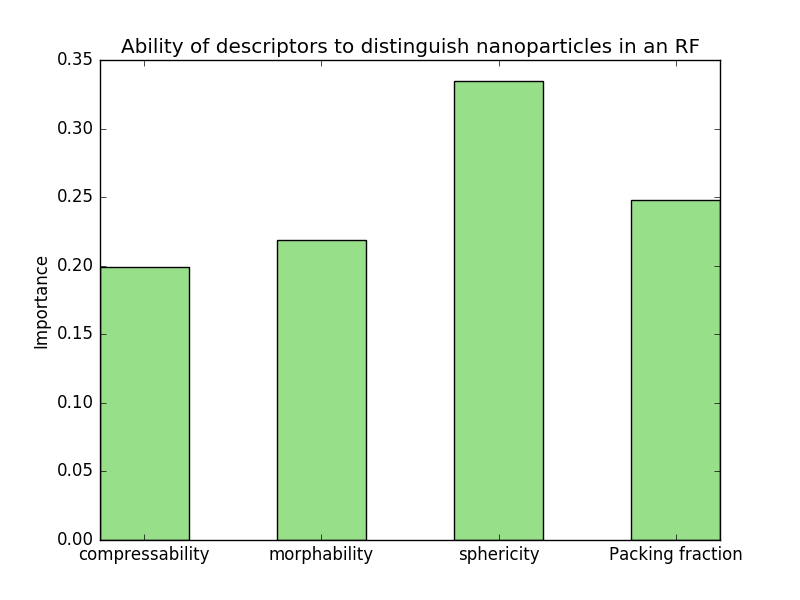

In [199]:
fig, ax = plt.subplots()
rects = ax.bar(np.arange(4),rforests.feature_importances_,width=0.5, color=tableau4_light[1])
ax.set_ylabel('Importance')
ax.set_title('Ability of descriptors to distinguish nanoparticles in an RF')
ax.set_xticks(np.arange(4)+0.25)
ax.set_xticklabels(['compressability','morphability','sphericity','Packing fraction'],rotation=0)

plt.savefig('DescriptorImportance.png',format='png')
Image('DescriptorImportance.png')

Looking at compounds that appear most nanoparticle-like most nanoparticle like in the out-of-the-bag estimates of the random forest.

In [255]:
#scores = rforests.predict_proba(des)[:,1] # If using in full model predictions
scores = rforests.oob_decision_function_[:,1] # If using in out of the bag samples
comb = zip(ligs,scores)

for l,s in zip(ligs,scores):
    if l in true_nanos and s > 0.5:
        print l,'correctly predicted to be nanoparticle'
    if l not in true_nanos and s < 0.5:
        print l,'correctly predicted to NOT form nanoparticle'

4r correctly predicted to be nanoparticle
5s correctly predicted to NOT form nanoparticle
9t correctly predicted to be nanoparticle
